# Overview Classifier 

Used supervised machine learning to train a classifier based on the heuristic classes, then apply that classifier to the Overview topic. 

In [7]:
import csv

import numpy as np 

## Document Loading 

In [2]:
doc_lookup = {}

with open("data/lit-review-doc-metadata.csv", "r") as f:
    reader = csv.DictReader(f)
    for row in reader:
        doc_lookup[row["Document Title"]] = row

print(len(doc_lookup.keys()))

9734


In [139]:
def load_documents(path="data/lit-review-categories.csv", ignore=()):
    not_found = 0
    with open(path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["Document Title"] in doc_lookup:
                doc_lookup[row["Document Title"]]["Label"] = row["Domain"]
            else:
                not_found += 1

    print("Missing docs: {}".format(not_found))
    
    docs = [d for d in doc_lookup.values() if "Label" in d and d["Label"] not in ignore] 
    print("Filtered docs: {}".format(len(docs)))

    return [d["Abstract"] for d in docs], [d["Label"] for d in docs]


IGNORE = [
    "Exclude",
    "Overview",
    "PMU Placement",
    "PMU",
    "PDC",
    "Unknown",
    "Undefined",
    "Control",
    "Communications",
    "Phasor Estimation",
    "Simulation",
    "Islanding",
    "Time Synchronization"
    "Testing",
    "Real Time Operations",
    "Tools",
    "EMS",
    "Standards",
    "",
    "Phasor estimation",
    "Protection Systems",
    # The following have too few classes 
    'Alarms', 'Energy Storage', 'Excitation Systems', 'GMD',
    'Measurement Techniques, Awesome', 'Safety'
]

X, y = load_documents(ignore=IGNORE)

Missing docs: 296
Filtered docs: 3862


## Modeling and Cross-Validation

In [142]:
from sklearn.base import clone
from sklearn.pipeline import Pipeline 
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 

from sklearn.model_selection import cross_val_score

no_features = 750

tf_vec = CountVectorizer(
    max_df=0.8, min_df=2, max_features=no_features, stop_words='english', ngram_range=(1,3)
)

tfidf_vec = TfidfVectorizer(**tf_vec.get_params())


def make_pipeline(model, idf=False):
    vec = tfidf_vec if idf else tf_vec 
    return Pipeline([
        ('vec', clone(vec)),
        ('clf', model), 
    ])

In [143]:
clf = make_pipeline(MultinomialNB())
cross_val_score(clf, X, y).mean()

0.5986610805189735

In [144]:
clf = make_pipeline(MultinomialNB(), idf=True)
cross_val_score(clf, X, y).mean()

0.5091022550732612

In [145]:
from sklearn.ensemble import GradientBoostingClassifier 

clf = make_pipeline(GradientBoostingClassifier(), idf=True)
cross_val_score(clf, X, y).mean()

0.5888289908536762

In [146]:
from sklearn.ensemble import GradientBoostingClassifier 

clf = make_pipeline(GradientBoostingClassifier(), idf=False)
cross_val_score(clf, X, y).mean()

0.6132842453137403

In [147]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(LogisticRegression(), idf=True)
cross_val_score(clf, X, y).mean()

0.6131759357427584

In [148]:
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(LogisticRegression(), idf=False)
cross_val_score(clf, X, y).mean()

0.5748877077588707

In [149]:
from yellowbrick.classifier import ClassificationReport, ClassBalance
from sklearn.model_selection import train_test_split as tts 
from sklearn.preprocessing import LabelEncoder

In [150]:
le = LabelEncoder().fit(y)

/Users/benjamin/.pyenv/versions/3.6.2/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


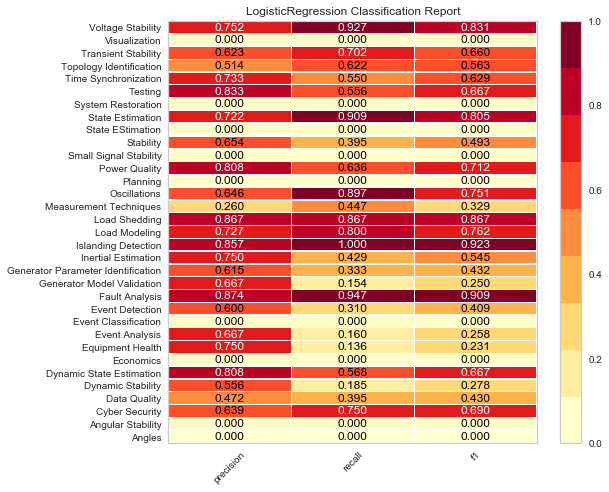

In [166]:
X_vec = clone(tfidf_vec).fit_transform(X)
X_train, X_test, y_train, y_test = tts(X_vec, np.array(y), test_size=0.3, stratify=np.array(y), shuffle=True)

_, ax = plt.subplots(figsize=(9,7))
cr = ClassificationReport(LogisticRegression(), ax=ax)
cr.fit(X_train, y_train)
cr.score(X_test, y_test)
cr.poof("/Users/benjamin/Dropbox/Screenshots/SGSMA pyLDAViz/classification_report.png")

## Selected Model

Currently selecting the TF-IDF LogisticRegression which had a simple cross-val scoe of 0.61

In [152]:
from sklearn.externals import joblib

clf = make_pipeline(LogisticRegression(), idf=True)
clf.fit(X, y)

joblib.dump(clf, 'maxent_tfidf_overview.joblib') 

['maxent_tfidf_overview.joblib']

## Assign to Overview 

In this section, we assign the classes to the papers in the overview section. 

In [153]:
len(clf.classes_)

33

In [154]:
clf.classes_

array(['Angles', 'Angular Stability', 'Cyber Security', 'Data Quality',
       'Dynamic Stability', 'Dynamic State Estimation', 'Economics',
       'Equipment Health', 'Event Analysis', 'Event Classification',
       'Event Detection', 'Fault Analysis', 'Generator Model Validation',
       'Generator Parameter Identification', 'Inertial Estimation',
       'Islanding Detection', 'Load Modeling', 'Load Shedding',
       'Measurement Techniques', 'Oscillations', 'Planning',
       'Power Quality', 'Small Signal Stability', 'Stability',
       'State EStimation', 'State Estimation', 'System Restoration',
       'Testing', 'Time Synchronization', 'Topology Identification',
       'Transient Stability', 'Visualization', 'Voltage Stability'],
      dtype='<U34')

In [155]:
def load_overview(path="data/lit-review-categories.csv"):
    with open(path) as f:
        reader = csv.DictReader(f)
        for row in reader:
            if row["Document Title"] in doc_lookup:
                doc_lookup[row["Document Title"]]["Label"] = row["Domain"]
    
    docs = [d for d in doc_lookup.values() if "Label" in d and d["Label"] == 'Overview'] 
    print("Filtered docs: {}".format(len(docs)))

    return docs


overview = load_overview()

Filtered docs: 730


In [156]:
def overview_info(idx=0):
    X = [overview[idx]['Abstract']]
    probs = dict(zip(clf.classes_, clf.predict_proba(X)[0]))
    probs["Label"] = clf.predict(X)[0]
    probs["Label Prob"] = probs[probs["Label"]]
    probs["Document Title"] = overview[idx]["Document Title"]
    return probs


with open('data/lit-overview-classified.csv', 'w') as f:
    fields = ['Document Title', 'Label', 'Label Prob',] + list(clf.classes_)
    writer = csv.DictWriter(f, fields)
    writer.writeheader()
    
    for idx in range(len(overview)):
        writer.writerow(overview_info(idx))

## Analysis of Classification

In [157]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

overview = pd.read_csv('data/lit-overview-classified.csv')

In [170]:
overview.groupby('Label')['Label'].count()

Label
Cyber Security              85
Data Quality                16
Dynamic Stability           14
Economics                    8
Equipment Health            11
Event Analysis              11
Event Detection              5
Fault Analysis              12
Inertial Estimation          1
Load Shedding                2
Measurement Techniques     342
Oscillations                45
Power Quality                6
Stability                   29
State Estimation            63
Testing                      9
Time Synchronization        11
Topology Identification     38
Transient Stability          2
Visualization                2
Voltage Stability           18
Name: Label, dtype: int64

In [172]:
THRESHOLD = 0.25

# What percent of documents do we lose if we set the label prob threshold?
overview[overview['Label Prob'] >= THRESHOLD].groupby('Label')['Label'].count().sum()

190

In [160]:
lbls100 = overview.groupby('Label')['Label'].count()
lbls35 = overview[overview['Label Prob'] >= 0.35].groupby('Label')['Label'].count()
lbls25 = overview[overview['Label Prob'] >= 0.25].groupby('Label')['Label'].count()
lbls15 = overview[overview['Label Prob'] >= 0.15].groupby('Label')['Label'].count()
lbls5 = overview[overview['Label Prob'] >= 0.05].groupby('Label')['Label'].count()

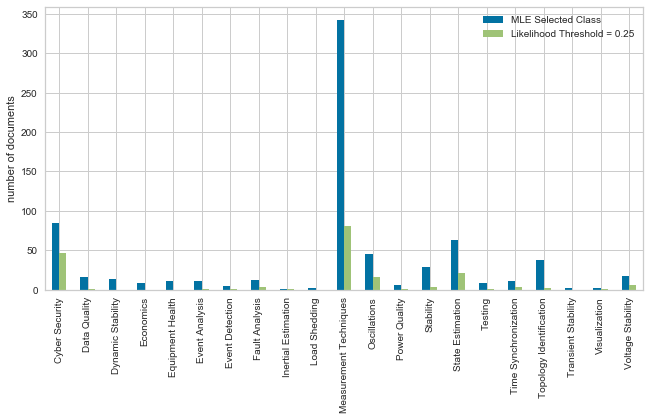

In [161]:
df = pd.concat([lbls100, lbls25], axis=1)
df.columns=["MLE Selected Class", "Likelihood Threshold = 0.25"]
df = df.fillna(0.0)


fig, ax = plt.subplots(figsize=(9,6))
df.plot(kind='bar', stacked=False,ax=ax)
plt.tight_layout()
ax.set_ylabel("number of documents")
plt.savefig("/Users/benjamin/Dropbox/Screenshots/SGSMA pyLDAViz/overview_categories.png")